In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from collections import OrderedDict
from scipy.ndimage import shift as shift_fn


from Joint_HDRDN import Joint_HDRDN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:

def bayer_to_rgb(bayer_array):
    H, W = bayer_array.shape[1:]
    bayer = np.zeros((H * 2, W * 2), dtype=bayer_array.dtype)
    bayer[0::2, 0::2] = bayer_array[0]
    bayer[0::2, 1::2] = bayer_array[1]
    bayer[1::2, 0::2] = bayer_array[2]
    bayer[1::2, 1::2] = bayer_array[3]

    bayer = np.clip(bayer, 0, 1)
    bayer = (bayer * 65535).astype(np.uint16)

    #print("Max value before demosaicing:", np.max(bayer))

    rgb = cv2.cvtColor(bayer, cv2.COLOR_BayerBG2RGB)

    rgb = rgb.astype(np.float32) / 65535.0

    #print("Max RGB value after demosaicing:", np.max(rgb))

    # --- Normalize to maximum brightness ---
    if np.max(rgb) > 0:
        rgb = rgb / np.max(rgb)

    # Optional: Apply gamma correction (makes image bright and natural)
    rgb = np.clip(rgb, 0, 1) ** (1/2.2)

    return rgb


In [3]:
def to_tensor(np_array):
    t = torch.from_numpy(np_array).float()
    return t
def data_load(npypath):
    imdata = np.load(npypath)

    #sht = imdata['sht']
    mid = imdata['mid']
    #lng = imdata['lng']
    hdr = imdata['hdr']

    mid = to_tensor(mid).to(device).unsqueeze(0)
    hdr = to_tensor(hdr).to(device).unsqueeze(0)
    
    return mid, hdr

In [4]:
def phase_correlation_shift(img1, img2):
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    shift, _ = cv2.phaseCorrelate(img1, img2)
    return shift

In [38]:
def shift_adjustment(img, shift):
    a = round(shift[0])
    b = round(shift[1])
    shifted_gt = np.roll(np.roll(img, shift=-a, axis=1), shift = -b, axis=0)
    return shifted_gt

In [13]:
def shift_image_subpixel(img, shift):
    a = -shift[1]
    b = -shift[0]
    shifted = np.zeros_like(img)
    for c in range(3):
        shifted[:, :, c] = shift_fn(img[:, :, c], shift=(a, b), order=0, mode='nearest')  # order=0
    return shifted

In [14]:
def global_shift(mid, gt):
    shifted_gt_list = []

    for b in range(gt.shape[0]):
        mid_numpy = mid[b][:4, :, :].squeeze().cpu().numpy()
        gt_numpy = gt[b].squeeze().cpu().numpy()

        mid_rgb = bayer_to_rgb(mid_numpy)
        gt_rgb = bayer_to_rgb(gt_numpy)

        initial_shift = phase_correlation_shift(mid_rgb, gt_rgb)
        shifted_gt_rgb = shift_image_subpixel(gt_rgb, initial_shift) #(H,W,C)
        after_shift = phase_correlation_shift(mid_rgb, shifted_gt_rgb)

        shifted_gt_tensor = to_tensor(shifted_gt_rgb).permute(2, 0, 1)  # Should be (C,H,W)
        shifted_gt_list.append(shifted_gt_tensor)

    shifted_gt_batch = torch.stack(shifted_gt_list, dim=0)  # (B, C, H, W)

    return shifted_gt_batch, initial_shift, after_shift


In [15]:
npypath = '/data/asim/ISP/HDR_transformer/data/RAW/2022-0708-1630-2434.npz'
mid, gt = data_load(npypath)
#print(mid.shape)
#print(gt.shape)
shifted_gt_rgb, intial_shift, after_shift = global_shift(mid, gt)
shifted_gt_rgb.shape, intial_shift, after_shift

(torch.Size([1, 3, 3456, 4608]),
 (-17.10400640713806, 1.0672462433888086),
 (-0.10567152960038584, 0.07038063961977059))

In [ ]:
path = './Results'
os.makedirs(path, exist_ok=True)
diff = gt-shifted_gt_rgb
imgs = [im2_rgb, gt, shifted_gt, shifted_gt_1, diff]
labels = ['mid', 'GT', 'Shifted_GT', 'Shifted_GT_1', 'Diff']  

for img, label in zip(imgs, labels):
    plt.figure(figsize=(6, 6))
    plt.imshow(np.clip(img, 0, 1))  
    plt.axis('off')
    plt.tight_layout()
    save_path = os.path.join(path, f'{label}.png')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()


In [42]:
npypath = '/data/asim/ISP/HDR_transformer/data/RAW/2022-0708-1630-2434.npz'
im2_rgb, gt = data_load(npypath)
print(im2_rgb.shape)
print(gt.shape)
for b in range(gt.shape[0]):
    mid_numpy = im2_rgb[b][:4, :, :].squeeze().cpu().numpy()
    print(mid_numpy.shape)
    gt_numpy = gt.squeeze().cpu().numpy()
    print(gt_numpy.shape)
    mid_rgb = bayer_to_rgb(mid_numpy)
    gt_rgb = bayer_to_rgb(gt_numpy)
    print(mid_rgb.shape)
intial_shift = phase_correlation_shift(im2_rgb, gt)
shifted_gt = shift_adjustment(gt, intial_shift)
after_shift = phase_correlation_shift(im2_rgb, shifted_gt)
shifted_gt_1 = shift_image_subpixel(gt, intial_shift)
after_shift_1 = phase_correlation_shift(im2_rgb, shifted_gt_1)
intial_shift, after_shift, after_shift_1

torch.Size([1, 8, 1728, 2304])
torch.Size([1, 4, 1728, 2304])
(4, 1728, 2304)
(4, 1728, 2304)
(3456, 4608, 3)


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


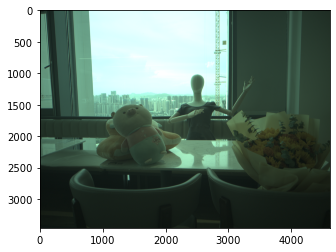

In [ ]:
plt.imshow(im2_rgb)

In [ ]:
npypath = '/data/asim/ISP/HDR_transformer/data/RAW/2022-0708-1630-2434.npz'
im2_rgb, gt = data_load(npypath)
intial_shift = phase_correlation_shift(im2_rgb, gt)
shifted_gt_1 = shift_image_subpixel(gt, intial_shift)
(gt-shifted_gt_1).max()

0.5813455

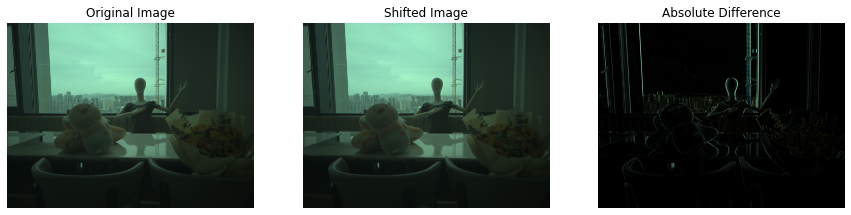

In [ ]:


def visualize_difference(img1, img2):
    # Compute absolute difference
    diff = np.abs(img1.astype(np.float32) - img2.astype(np.float32))
    diff = diff / diff.max()  # Normalize to [0,1] for display

    # Plot
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img1)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Shifted Image')
    plt.imshow(img2)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Absolute Difference')
    plt.imshow(diff)
    plt.axis('off')
    save_path = os.path.join(path, f'diff.png')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

# Example usage
original_img = gt  # your original image
shifted_img = shift_image_subpixel(gt, intial_shift)  # shifted

visualize_difference(original_img, shifted_img)


In [ ]:
20 * np.log10(1 / 1e-3)


60.0

In [ ]:
(gt-shifted_gt_1).max()

0.8315519